### Notebook demonstrating how to clip DEMs upstream of a given point

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import sys
sys.path.append('../python/')
import lem
from shapely.geometry import shape
from rasterio.features import shapes

## Define custom functions

In [2]:
def snap_pourpoint(acc, basin_y, basin_x, pt_y, pt_x, target_area, dA,search_area):
        """
        Parameters
        acc: Accumulation grid
        basin_y: Lat vector for DEM
        basin_x: LOn vector for DEM
        pt_y: Lat of pour point
        pt_x: Lon of pour point
        target_area: Minimum drainage area for snap
        dA: cell size in m2
        search_area: Search area for snap (fraction of DEM

        Returns
        ysnap and xsnap - LAT , LON of new snapped pour point

        """
        x = np.argmin((basin_x - pt_x) ** 2)
        y = np.argmin((basin_y - pt_y) ** 2)
        A1=0
        w=1
        m,n = np.shape(acc)
        while A1< target_area:
                ny, nx = np.where(acc[y-w:y+w+1,x-w:x+w+1]>= np.max(acc[y-w:y+w+1,x-w:x+w+1])/1.25) # We find the closest point within the min
                print('here')
                xysnap = np.argmin((ny - w) ** 2 + (nx - w) ** 2)
                ysnap = ny[xysnap] + y - w
                xsnap = nx[xysnap] + x - w
                A1 = acc[ysnap,xsnap] * dA
                print(A1)
                w+=1
                if w>search_area*(m/2+n/2):
                    break
        return ysnap, xsnap


In [3]:


def generate_pour_point_catchment(filenm, outnm, pt, fillsink = True, target_area = 1e5, search_area =.05,flowdir=None):
        """
        Parameters
        filenm: Location/Name of input DEM
        outnm: Base Location/name of outputs
        pt: Pour Point Lat,Lon
        fillsink: Fill DEM sinks?
        target_area: Minimum area to snap to
        search_area: Area to search as a fraction of the whole DEM

        Returns
        df: GeoDataFrame shape of your basin
        acc: Acumulation grid

        """
        DEM = lem.simple_model() #Initiate the grid object
        DEM.turn_on_off_dynamic_bc('False') #This means that outlets are assigned, not dynamic i.e. everywhere below sea level.
        f = rio.open(filenm) #File containing DEM
        Z = np.float64(np.squeeze(f.read()))
        m,n = np.shape(Z)
        DEM.set_z(Z)





        lat = np.array([f.xy(i,0)[1] for i in range(m)])
        lon = np.array([f.xy(0,i)[0] for i in range(n)])
        dL =  111000 * np.cos(np.mean(pt[1]) * np.pi / 180) # m per degree
        dx = np.mean(np.diff(lon)) * dL #m per pixel, avg x
        print('dx='+str(dx))
        dy = np.mean(np.diff(lat)) * 111000 # m per pixel, avg y
        dA=dy*dx
        DEM.dx = dx
        DEM.dy = dy
        if fillsink:
                DEM.sinkfill()
        DEM.slp()
        if flowdir is not None:
            DEM.receiver=flowdir

        DEM.stack()
        DEM.acc()
        acc = DEM.A.copy()

        ys,xs = snap_pourpoint(acc, lat, lon, pt[0], pt[1], target_area, dA,search_area)
        DEM.pour_point = np.int64([ys, xs])
        DEM.stack()
        DEM.acc()
        Z = np.zeros(np.shape(DEM.get_z())).ravel(order='F')
        Zi = DEM.get_z().ravel(order='F')
        for i in range(len(DEM.stackij)):
                Z[DEM.stackij[i]] = Zi[DEM.stackij[i]]

        Z = Z.reshape(m,n,order='F')
        Z[0,0]=0
        profile = f.profile

        Z[Z==0] = -9999
        Z[Z>0] = 1

        with rio.open(outnm + '.tif', 'w', **profile) as dst:
                dst.write(Z.astype(rio.float64), 1)

        with rio.open(outnm+'.tif') as src:
                data = src.read(1)
                mask = data != src.nodata  # Or use a condition like data > 0
                transform = src.transform

        shapes_gen = shapes(data.astype(np.uint8), mask=mask, transform=transform)
        geoms = [shape(geom) for geom, value in shapes_gen if value == 1]
        df = gpd.GeoDataFrame(geometry=geoms)#.dissolve()
        df.to_file(outnm)
        return df, acc


## Example for NZ with lake filling

In [4]:
filenm = '../example_data/nz_dems/nz_bas_hydroshed_10_.tif' #input file name for DEM
outnm = '../example_data/nz_dems/nz_bas_hydroshed_10_output' #output for DEM
pt = [-41.62, 172.8] # The relevant pour point

target_area = 1e5 # Threshold minimum drainage area to snap to (best guess)
search_area = .05 # Search area for the snap, as a fraction of the total DEM area
df,A=generate_pour_point_catchment(filenm, outnm, pt, target_area = 1e5, search_area =.05)

[944, 925]
500 500
(944, 925)
Boundary condition values have been reset
dx=-29.67801893302543
here
here
6214.496818113523
here
7990.06733757453
here
21306.84623353208
here
21306.84623353208
here
21306.84623353208
here
29296.91357110661
here
34623.62512948963
here
37286.98090868114
here
79012.88811601479
here
79012.88811601479
here
86115.17019385882
here
104758.6606481994


<Axes: >

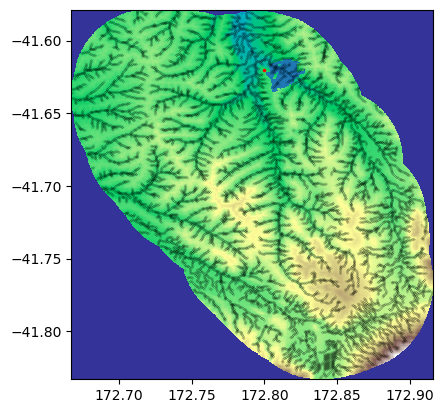

In [5]:
fig,ax = plt.subplots(1,1)
f = rio.open(filenm) #File containing DEM
Z=np.float64(np.squeeze(f.read()))
m,n = np.shape(Z)
lat = np.array([f.xy(i,0)[1] for i in range(m)])
lon = np.array([f.xy(0,i)[0] for i in range(n)])
plt.pcolormesh(lon,lat,Z,cmap='terrain')
athres = 100 #threshold drainage area for plotting
IJ = np.where((A>athres) & (Z>=1))
plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
plt.plot(pt[1],pt[0],'.r',markersize=3)
df.plot(ax=ax)


## Example for Aus without lake filling

In [12]:
# Format flow dir raster -
# raster is in relative direction format 1 = E, 2 = SE, 4=S, 8=SW, 16 = W, 32 =NW, 64 =N, 128 = NE
# We must revise it so that it is in the format of the receiver grid - absolute (row major) location

R = rio.open('/users/gr_1/Downloads/clipped_flow.tif')
flowdir = np.squeeze(R.read())
ny,nx = np.shape(flowdir)
flowdir_revised = np.zeros((ny,nx))
flowdir_revised[flowdir==1]=ny
flowdir_revised[flowdir==2]=ny+1
flowdir_revised[flowdir==4]=1
flowdir_revised[flowdir==8]=-ny+1
flowdir_revised[flowdir==16]=-ny
flowdir_revised[flowdir==32]=-ny-1
flowdir_revised[flowdir==64]=-1
flowdir_revised[flowdir==128]=ny-1
add_vec = np.arange(ny*nx).reshape(ny,nx,order='F')
flowdir_revised+=add_vec
flowdir_revised[flowdir_revised<0]=0
flowdir_revised[0,:]=add_vec[0,:]
flowdir_revised[-1,:]=add_vec[-1,:]
flowdir_revised[:,0]=add_vec[:,0]
flowdir_revised[:,-1]=add_vec[:,-1]
flowdir_revised=np.int64(flowdir_revised)

In [ ]:
filenm = '/Users/gr_1/Downloads/clipped_dem.tif'
outnm =  '/Users/gr_1/Downloads/out_aus' #output for DEM
pt = [-23.986083, 134.7173]
df,A=generate_pour_point_catchment(filenm, outnm, pt,
                                   fillsink=False,
                                   target_area = 1e8,
                                   search_area =.05,flowdir=flowdir_revised)


[3648, 6822]
500 500
(3648, 6822)
Boundary condition values have been reset
dx=-195.25157823310175


<Axes: >

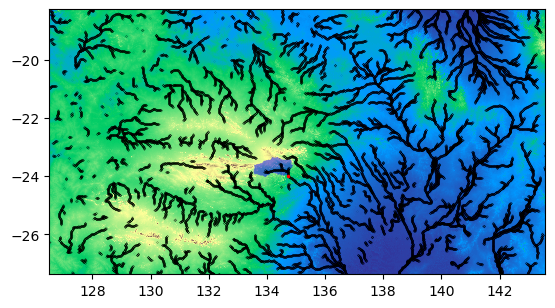

In [11]:
fig,ax = plt.subplots(1,1)
f = rio.open(filenm) #File containing DEM
Z=np.float64(np.squeeze(f.read()))
m,n = np.shape(Z)
lat = np.array([f.xy(i,0)[1] for i in range(m)])
lon = np.array([f.xy(0,i)[0] for i in range(n)])
plt.pcolormesh(lon,lat,Z,cmap='terrain')
athres = 10000 #threshold drainage area for plotting
IJ = np.where((A>athres) & (Z>=1))
plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
plt.plot(pt[1],pt[0],'.r',markersize=3)
df.plot(ax=ax,color='blue',alpha=.5)

